In [10]:
import sys
import numpy as np
import scipy.linalg as la
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import os
import pandas as pd
from prettytable import PrettyTable
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
sys.path.append(os.getenv("HOME") + '/repos/pyQSYS/build/qsys')
from pyQSYS import *

In [11]:
# n = 4
# mine_graph = {3: [0, 1, 2], 0: [], 1: [], 2: []}
# profit = [-2.0, 3.0, 1.0, 5.0]
n = 9
mine_graph = {5: [0, 1, 2],
             6: [1, 2, 3],
             7: [2, 3, 4],
             8: [5, 6, 7],
             0: [],
             1: [],
             2: [],
             3: [],
             4: []}
profit = [-2.0, 3.0, -1.0, -2.0, -1.0, 1.0, -5.0, 10.0, 4.0]
ncols, nrows = 5, 3
cord2idx = {(0, 0): 0,
 (0, 1): 1,
 (0, 2): 2,
 (0, 3): 3,
 (0, 4): 4,
 (1, 1): 5,
 (1, 2): 6,
 (1, 3): 7,
 (2, 2): 8}

In [12]:
model = SpinHalf(n, 1)
statemap = model.createStateMap()
dig_state = ["{0:09b}".format(x) for x in statemap.states]

In [13]:
def H_p(mine_graph, n):
    H_op = Operator()
    for idx in range(n): 
        H_op += profit[idx]*(Sz_(model.sites()[idx])-0.5)
    return H_op

def H_s(mine_graph, n):
    H_op = Operator()
    for p in mine_graph:
        for c in mine_graph[p]:
            H_op += (0.5-Sz_(model.sites()[p]))*(0.5+Sz_(model.sites()[c]))
    return H_op

def H_b(n):
    H_op = Operator()
    for idx in range(n): 
        H_op += Sx_(model.sites()[idx])
    return 2.0*H_op

In [14]:
def plot_mine_state(bitstring):
    x = PrettyTable([' ']+[str(ic) for ic in range(ncols)])
    for ir in range(nrows):
        x.add_row([ir]+[bitstring[cord2idx[(ir, ic)]] if (ir, ic) in cord2idx else 'x'
                        for ic in range(ncols)])
    print(str(x))

## Eigenstate Check 

In [11]:
lbd = 5.0
H_prob = H_p(mine_graph, n) + lbd*H_s(mine_graph, n)

In [23]:
# Ham = CSRMatrix('double', H_prob, model, statemap)
# eigenvalues, eigenvectors = spla.eigsh(Ham, k=2)
Ham = DenseMatrix('double', H_prob, model, statemap)
#evals, evecs = la.eigh(Ham)

In [31]:
dig_state[353][::-1]

'100001101'

## Energy Gap

In [15]:
lbd = 5.0
H_prob = H_p(mine_graph, n) + lbd*H_s(mine_graph, n)
H_basic = H_b(n)

In [16]:
time = np.arange(0, 1.02, 0.02)
ground = np.zeros(len(time))
first_excite = np.zeros(len(time))

In [17]:
for idx in range(len(time)):
    t = time[idx]
    H = t*H_prob + (1-t)*H_basic
    Ham = DenseMatrix('double', H, model, statemap)
    evals, evecs = la.eigh(Ham)
    
    ground[idx] = evals[0]
    first_excite[idx] = evals[1]

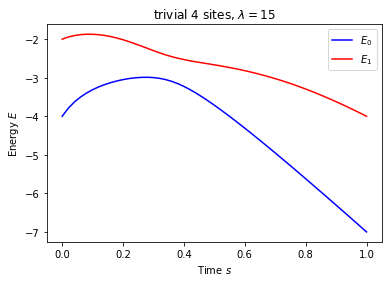

In [9]:
plt.plot(time, ground, 'b', label=r'$E_{0}$')
plt.plot(time, first_excite, 'r', label=r'$E_{1}$')
plt.ylabel(r'Energy $E$')
plt.xlabel('Time $s$')

plt.title('trivial 4 sites, '+f'$\lambda=15$')
plt.legend()

plt.show()

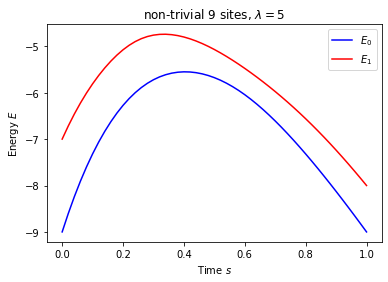

In [18]:
plt.plot(time, ground, 'b', label=r'$E_{0}$')
plt.plot(time, first_excite, 'r', label=r'$E_{1}$')
plt.ylabel(r'Energy $E$')
plt.xlabel('Time $s$')

plt.title('non-trivial 9 sites, '+f'$\lambda=5$')
plt.legend()

plt.show()

## Time Evolution

In [6]:
lbd = 5.0
H_prob = H_p(mine_graph, n) + lbd*H_s(mine_graph, n)
H_basic = H_b(n)

In [7]:
# ground state of H basic
Ham = DenseMatrix('double', H_basic, model, statemap)
evals, evecs = la.eigh(Ham)
init_state = evecs[:, 0]

In [8]:
init_state.T@Ham@init_state

-9.0

In [9]:
T = 40
nstep = 400

delT = T / nstep
time = np.arange(0, T+delT, T/nstep) / T

In [10]:
state = init_state
Hp = DenseMatrix('double', H_prob, model, statemap)
Hb = DenseMatrix('double', H_basic, model, statemap)

In [11]:
for it, t in enumerate(time):
    state = la.expm(-delT*1.j*t*Hp)@state
    state = la.expm(-delT*1.j*(1-t)*Hb)@state
    if it%40 == 0:
        prob = list(map(lambda x:x.real**2+x.imag**2, state))
        print(f"most probable state: {dig_state[np.argmax(prob)]}")
        print(f"probability: {np.max(prob)}")
        print("--------------------------------------------------")
        

most probable state: 101100001
probability: 0.0019531250000000043
--------------------------------------------------
most probable state: 101100001
probability: 0.010127147294163244
--------------------------------------------------
most probable state: 101100001
probability: 0.04479175679156988
--------------------------------------------------
most probable state: 101100001
probability: 0.11834601486632051
--------------------------------------------------
most probable state: 101100001
probability: 0.24177295780681834
--------------------------------------------------
most probable state: 101100001
probability: 0.43610811818982054
--------------------------------------------------
most probable state: 101100001
probability: 0.6567909401093852
--------------------------------------------------
most probable state: 101100001
probability: 0.866170106643494
--------------------------------------------------
most probable state: 101100001
probability: 0.9454464541052259
-----------------

In [12]:
prob = list(map(lambda x:x.real**2+x.imag**2, state))

In [12]:
#s = dig_state[np.argmax(prob)]
s = '101100001'
fs = list(s)[::-1]
ffs = ''.join([str(int(c == '0')) for c in fs])

In [13]:
plot_mine_state(ffs)

+---+---+---+---+---+---+
|   | 0 | 1 | 2 | 3 | 4 |
+---+---+---+---+---+---+
| 0 | 0 | 1 | 1 | 1 | 1 |
| 1 | x | 0 | 0 | 1 | x |
| 2 | x | x | 0 | x | x |
+---+---+---+---+---+---+


In [11]:
plot_mine_state('010011110')

+---+---+---+---+---+---+
|   | 0 | 1 | 2 | 3 | 4 |
+---+---+---+---+---+---+
| 0 | 0 | 1 | 0 | 0 | 1 |
| 1 | x | 1 | 1 | 1 | x |
| 2 | x | x | 0 | x | x |
+---+---+---+---+---+---+


In [ ]:
'101100001'